In [20]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score
%matplotlib inline

In [21]:
headers_data = '''1. symboling: -3, -2, -1, 0, 1, 2, 3. 
2. normalized-losses: continuous from 65 to 256. 
3. make: alfa-romero
4. fuel-type: diesel, gas. 
5. aspiration: std, turbo. 
6. num-doors: four, two. 
7. body-style: hardtop, wagon, sedan, hatchback, convertible. 
8. drive-wheels: 4wd, fwd, rwd. 
9. engine-location: front, rear. 
10. wheel-base: continuous from 86.6 120.9. 
11. length: continuous from 141.1 to 208.1. 
12. width: continuous from 60.3 to 72.3. 
13. height: continuous from 47.8 to 59.8. 
14. curb-weight: continuous from 1488 to 4066. 
15. engine-type: dohc, dohcv, l, ohc, ohcf, ohcv, rotor. 
16. num-cylinders: eight, five, four, six, three, twelve, two. 
17. engine-size: continuous from 61 to 326. 
18. fuel-system: 1bbl, 2bbl, 4bbl, idi, mfi, mpfi, spdi, spfi. 
19. bore: continuous from 2.54 to 3.94. 
20. stroke: continuous from 2.07 to 4.17. 
21. compression-ratio: continuous from 7 to 23. 
22. horsepower: continuous from 48 to 288. 
23. peak-rpm: continuous from 4150 to 6600. 
24. city-mpg: continuous from 13 to 49. 
25. highway-mpg: continuous from 16 to 54. 
26. price: continuous from 5118 to 45400.
'''

non_numeric_cols = ['make', 'fuel_type', 'aspiration', 'body_style',
                    'drive_wheels', 'engine_location', 'engine_type', 'fuel_system']

numbers = {
    'two': 2,
    'three': 3,
    'four': 4,
    'five': 5,
    'six': 6,
    'eight': 8,
    'twelve': 12
}

In [22]:
def get_headers():
    headers = []
    for line in headers_data.splitlines():
        name = re.findall('[0-9]+\.\s(.+):', line)[0]
        name = name.replace('-', '_')
        headers.append(name)
    return headers

def normalize_data(df):
    return (df - df.min()) / (df.max() - df.min())

In [23]:
cars = pd.read_csv('imports-85.data', header=None, names=get_headers())

# Clean data
cars.replace('?', np.nan, inplace=True)
cars['normalized_losses'] = cars.normalized_losses.astype(float)
cars.dropna(subset=['price'], inplace=True)
cars['price'] = cars.price.astype(float)
cars['num_doors'] = cars.num_doors.map(numbers)
cars['num_cylinders'] = cars.num_cylinders.map(numbers)

for col in cars.columns.difference(non_numeric_cols):
    if cars[col].dtype == 'O':
        cars[col] = pd.to_numeric(cars[col])

# Drop missing values
columns_with_missing_values = cars.isnull().sum()
# select columns to drop values from except for normalized_losses
to_drop = (columns_with_missing_values[columns_with_missing_values > 0].
           sort_values(ascending=False)[1:].index)

cars.dropna(subset=to_drop, inplace=True)
cars.normalized_losses.fillna(value=cars.normalized_losses.mean(), inplace=True)

# Normalize data
cars_norm = normalize_data(cars[cars.columns.difference(non_numeric_cols)])
cars_norm['price'] = cars['price']

In [24]:
def knn_train_test(train_cols, target, df, k=5):
    if isinstance(train_cols, str):
        train_cols = [train_cols]
    test_df = df.sample(frac=0.25, random_state=1)
    train_df = df.loc[df.index.difference(test_df.index)]
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(train_df[train_cols], train_df[target])
    predictions = knn.predict(test_df[train_cols])
    return mean_squared_error(test_df[target], predictions) ** (1/2)

def calc_knn_n_values(train, target, df, k_values):
    results = {
        k: knn_train_test(train, target, cars_norm, k)
        for k in k_values
    }
    return pd.Series(results)

def train_all_columns(target, df, k_values):
    if isinstance(k_values, int):
        k_values = [k_values]
    results_all = {}
    for k in k_values:
        results = {
            col: knn_train_test(col, target, df, k)
            for col in df.columns.drop(target)
        }
        results_all[k] = results
    
    return pd.DataFrame(results_all).T

def get_best_performing_attrs(df, n):
    df = pd.concat([df[col].sort_values().head(n) for col in df.columns], axis=1)
    results = (df.assign(
            appearances=df.isnull().sum(axis=1),
            mean_value=df.mean(axis=1)).
            sort_values(['appearances', 'mean_value'])
            .index.values)
    return results[:n]

#### Best 3 performing attributes for univariate k-nearest neighbors model:

In [25]:
use_cols = cars_norm.columns.copy()
results = {
    col: knn_train_test(col, 'price', cars_norm)
    for col in use_cols.drop('price')
}
pd.Series(results).sort_values().head(3)

engine_size    2917.537270
highway_mpg    3471.493857
city_mpg       3591.304678
dtype: float64

#### Univariate models for all columns using the following k values (1, 3, 5, 7, 9).

In [26]:
res_all = train_all_columns('price', cars_norm, range(1,10,2))

In [27]:
res_all

,bore,city_mpg,compression_ratio,curb_weight,engine_size,height,highway_mpg,horsepower,length,normalized_losses,num_cylinders,num_doors,peak_rpm,stroke,symboling,wheel_base,width
1,10253.239152,5749.823282,8770.227200,4662.479220,3555.364995,9221.512085,6669.911058,3972.820430,5636.716422,7729.710678,5259.143849,8212.172204,9330.138196,10847.117492,8361.463229,3232.095038,3926.685238
3,5356.412690,4172.252705,8772.117729,5214.646237,2137.808619,8199.532944,4050.961589,4728.973117,5359.859088,5916.581680,8645.181398,9055.038059,7942.721350,7380.304026,8113.264366,4281.242315,4327.061643
5,5908.183183,3591.304678,7038.374606,4466.725273,2917.537270,7694.528006,3471.493857,3615.713413,5051.407709,7007.706471,8727.242443,9328.856677,8629.850331,7727.306415,8845.262523,5287.020913,4219.800981
7,6699.063368,3499.818189,6379.824899,4322.709623,3196.488810,7332.841970,3762.431656,3251.225841,5204.351727,7601.676691,8290.925028,10545.742879,8089.814550,7707.268020,7950.593027,5456.321886,4370.610113
9,7142.745011,3339.118708,6546.367413,4122.875538,3170.477620,7628.882834,3940.869502,3686.496170,5206.993799,7547.872210,8270.764454,9811.604207,8011.357073,7706.298331,7593.811251,5823.093256,4486.189331


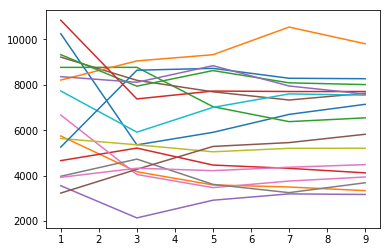

In [28]:
res_all.plot(legend=False)

#### Use the best n features from the previous step to train and test a multivariate k-nearest neighbors model using the default k value. Select top 3 models

In [29]:
top5attr = get_best_performing_attrs(
    train_all_columns('price', cars_norm, range(1,10,2)).T, 5)

top3models = sorted(
    [(top5attr[:i], knn_train_test(top5attr[:i], 'price', cars_norm))
     for i in range(2, len(top5attr) + 1)],
    key=lambda x: x[1])[:3]

top3models

[(array(['engine_size', 'horsepower', 'city_mpg'], dtype=object),
  2193.3248024783443),
 (array(['engine_size', 'horsepower', 'city_mpg', 'highway_mpg'],
        dtype=object), 2245.2930139145165),
 (array(['engine_size', 'horsepower'], dtype=object), 2569.303274722546)]

In [30]:
res = {}
for model in top3models:
    res[', '.join(model[0])] = calc_knn_n_values(model[0], 'price', cars_norm, range(1,26))

In [31]:
df = pd.DataFrame(res)

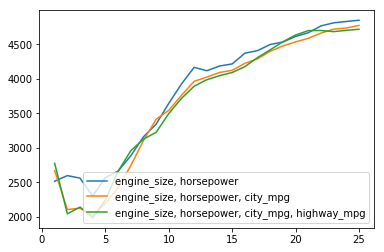

In [32]:
df.plot()

In [110]:
df.idxmin()

engine_size, horsepower                           4
engine_size, horsepower, city_mpg                 4
engine_size, horsepower, city_mpg, highway_mpg    4
dtype: int64

### Cross-validation

In [58]:
def calc_cross_val(folds, k_values, df, train_cols, target):
    res = {}
    for k in k_values:
        kf = KFold(folds, shuffle=True, random_state=1)
        knn = KNeighborsRegressor(k)
        mses = cross_val_score(knn, df[train_cols], df[target],
                               scoring="neg_mean_squared_error", cv=kf)
        rmses = np.sqrt(np.abs(mses))
        res[k] = rmses.mean()
    return pd.Series(res)

In [65]:


pd.DataFrame({', '.join(model[0]): calc_cross_val(4, range(1,26), cars_norm, model[0], 'price')
for model in top3models})

,"engine_size, horsepower","engine_size, horsepower, city_mpg","engine_size, horsepower, city_mpg, highway_mpg"
1,2810.514199,2885.562521,2943.422622
2,2782.889537,2586.028749,2701.512863
3,2906.158915,2730.495509,2884.578892
4,2916.777231,2779.178209,2867.560016
5,3112.868245,2899.410393,2897.733976
6,3196.799132,3033.819808,3091.460789
7,3249.309733,3173.886188,3237.396552
8,3352.467233,3331.898353,3315.528218
9,3503.689547,3472.089575,3434.052325
10,3636.593013,3567.811826,3589.994283
